# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.emfiles import crop_fourier_images, crop_fourier_volume
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

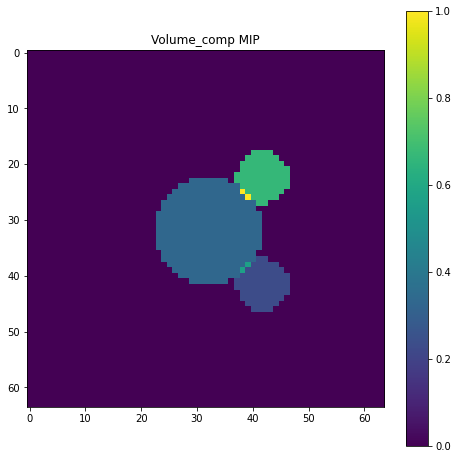

In [3]:
nx = 64
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0]])
radii = np.array([3, 1.5, 1.5])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid = volume_fourier(jnp.fft.ifftshift(vol), pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

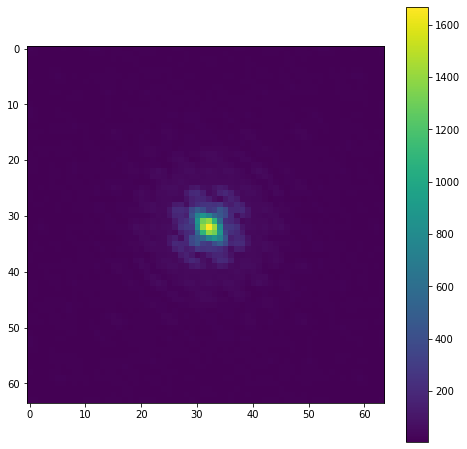

In [4]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [5]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


Generate projections (in Fourier domain)

1.864123821258545


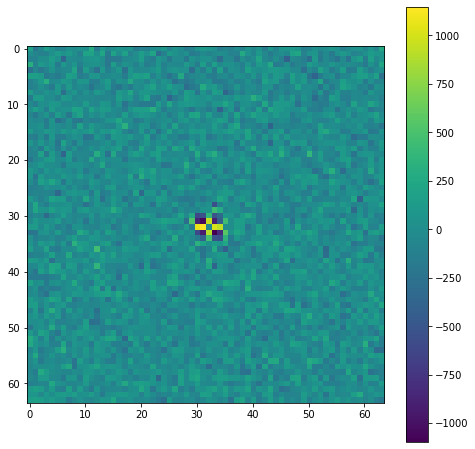

In [6]:
radius = 10
mask = create_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, y_grid, z_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)

N = 1000

# Non uniformly distributed orientations (here, two clusters)
#s = 0.05
s = 0.2
#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2

angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4

#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(int(N/2),3), s*np.random.randn(int(N/2),3)+np.pi], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

print(time.time()-start)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

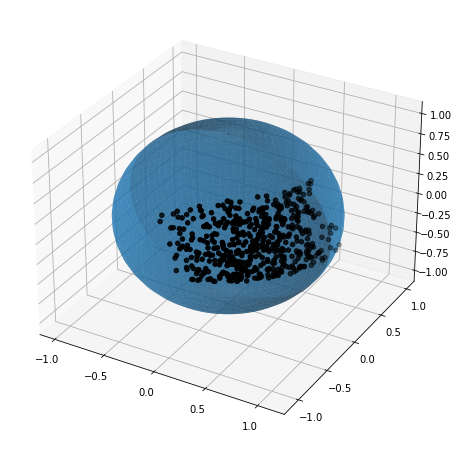

In [7]:
plot_angles(angles_true[:500])

### Crop images and volume:

In [8]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32
imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
imgs = imgs.reshape(imgs.shape[0], nx*nx)

vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

y_grid = x_grid
z_grid = x_grid

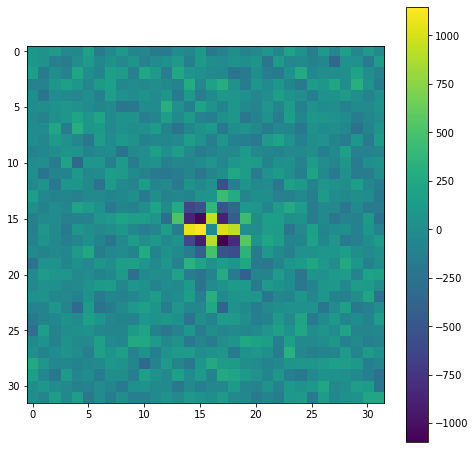

In [9]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

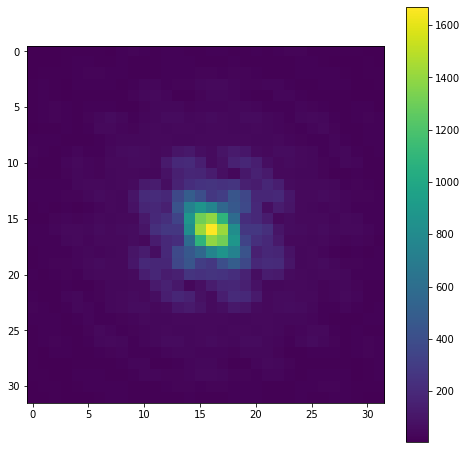

In [10]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

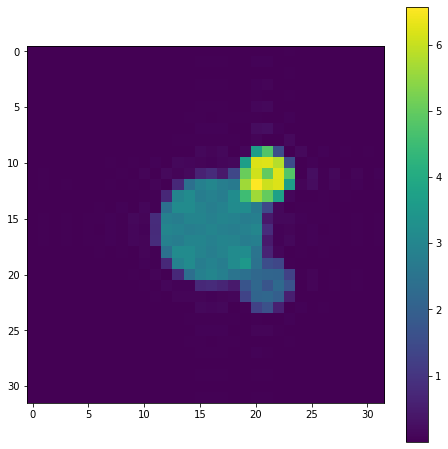

In [11]:
mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()

### Loss functions for the new dimension

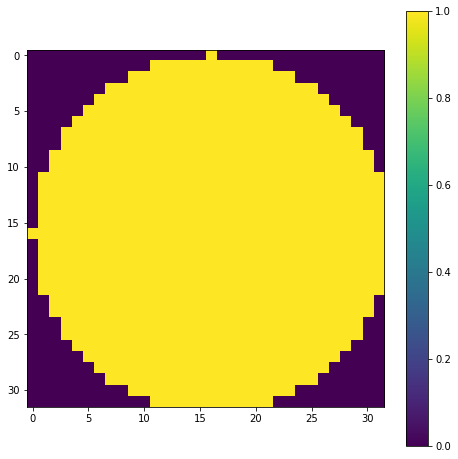

In [12]:
alpha = 0.001

radius = 0.8
mask = create_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, y_grid, z_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [13]:
start = time.time()
ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

1.4425456523895264
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [14]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

1.317183256149292
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [15]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

2.0587382316589355
(32, 32, 32)


## Optimization with respect to volume

### CG - applied to two halves of the data

In [16]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 100

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.5235066090231977
Iter 1 ||r|| = 0.22582881664061932
Iter 2 ||r|| = 0.1372299455529141
Iter 3 ||r|| = 0.09098493238368224
Iter 4 ||r|| = 0.07425551393760903
Iter 5 ||r|| = 0.06705719847576393
Iter 6 ||r|| = 0.055197688757168996
Iter 7 ||r|| = 0.04205961697907583
Iter 8 ||r|| = 0.03357510492657251
Iter 9 ||r|| = 0.02751311418456787
Iter 10 ||r|| = 0.024723211205673078
Iter 11 ||r|| = 0.022663866603868328
Iter 12 ||r|| = 0.021807676369458216
Iter 13 ||r|| = 0.019948988060909046
Iter 14 ||r|| = 0.016360351804655733
Iter 15 ||r|| = 0.012751396622015722
Iter 16 ||r|| = 0.013852831816548764
Iter 17 ||r|| = 0.013644967078008384
Iter 18 ||r|| = 0.01050331335440832
Iter 19 ||r|| = 0.009431485011151444
Iter 20 ||r|| = 0.008379172319666211
Iter 21 ||r|| = 0.007265080640876022
Iter 22 ||r|| = 0.006988981880282347
Iter 23 ||r|| = 0.006199152889314018
Iter 24 ||r|| = 0.006563572599139204
Iter 25 ||r|| = 0.004839144376987084
Iter 26 ||r|| = 0.004232878538982016
Iter 27 ||r|| = 0.00424

In [17]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.510518246222669
Iter 1 ||r|| = 0.22379773126924846
Iter 2 ||r|| = 0.13278566490807722
Iter 3 ||r|| = 0.08934146317114118
Iter 4 ||r|| = 0.07336769470382387
Iter 5 ||r|| = 0.06344198924696472
Iter 6 ||r|| = 0.056068900963609926
Iter 7 ||r|| = 0.04000888315411237
Iter 8 ||r|| = 0.033155669621738645
Iter 9 ||r|| = 0.02716043984111021
Iter 10 ||r|| = 0.024765942218712592
Iter 11 ||r|| = 0.021223752637931432
Iter 12 ||r|| = 0.01958222420249327
Iter 13 ||r|| = 0.019220985447138957
Iter 14 ||r|| = 0.016870881447431478
Iter 15 ||r|| = 0.0128114720103908
Iter 16 ||r|| = 0.01203614682311969
Iter 17 ||r|| = 0.011347420689021857
Iter 18 ||r|| = 0.010683058427266388
Iter 19 ||r|| = 0.010111077642437691
Iter 20 ||r|| = 0.007893505398688364
Iter 21 ||r|| = 0.007207704617021431
Iter 22 ||r|| = 0.0067853061488433435
Iter 23 ||r|| = 0.005910139709313839
Iter 24 ||r|| = 0.006682633838864559
Iter 25 ||r|| = 0.004795616768093591
Iter 26 ||r|| = 0.004445933259491273
Iter 27 ||r|| = 0.003784

In [18]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.7880627708043435
Absolute error =  34.45176688170541


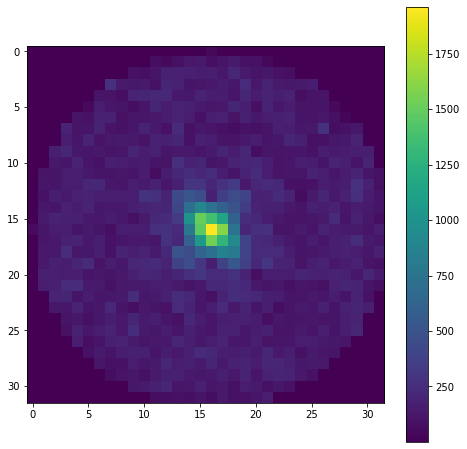

In [19]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; plt.colorbar()

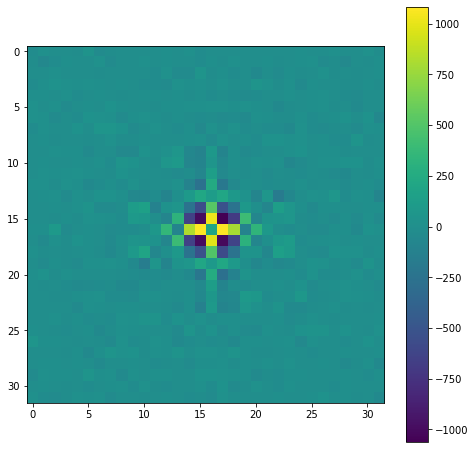

In [20]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

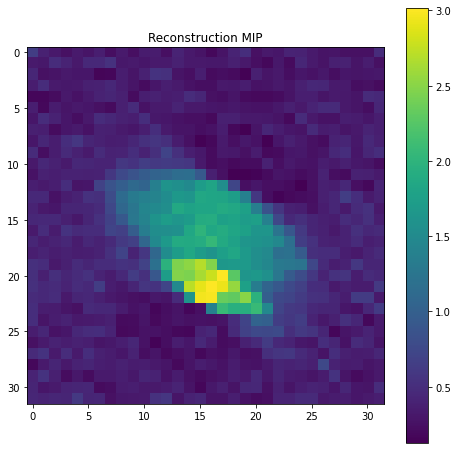

In [21]:
mip_x(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

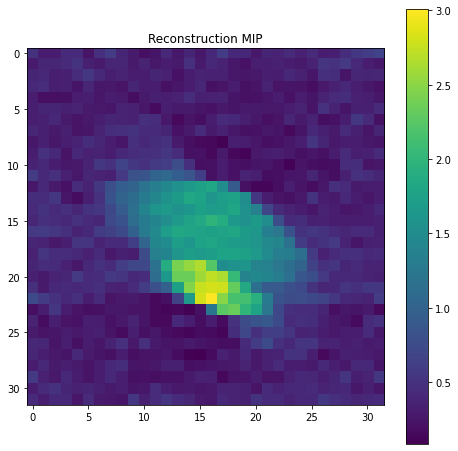

In [22]:
mip_x(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

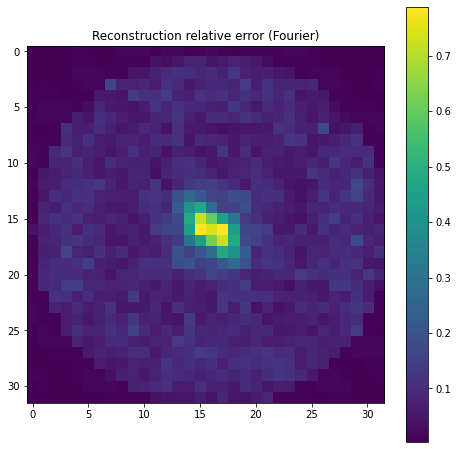

In [23]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

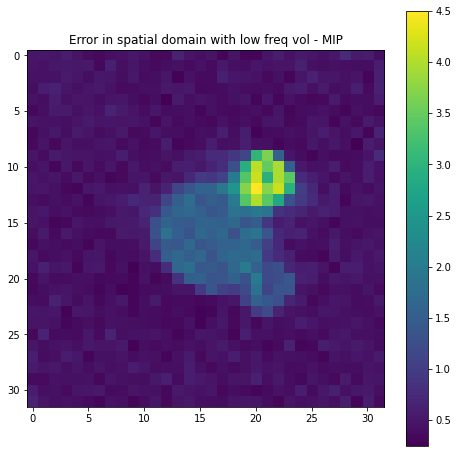

In [24]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [25]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

In [26]:
points_v_tri = points_orientations_tri(angles_true, x_grid, y_grid, z_grid)
points_v_nn = points_orientations_nn(angles_true, x_grid, y_grid, z_grid)

In [27]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

Text(0.5, 1.0, 'Clustered angles')

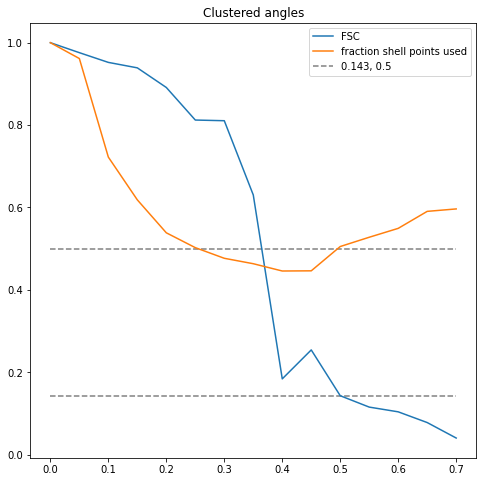

In [28]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
plt.title('Clustered angles')

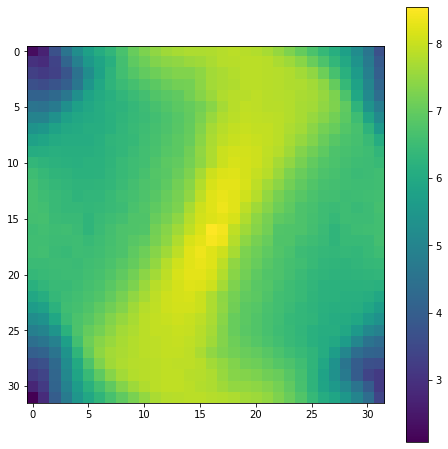

In [29]:
plt.imshow(jnp.fft.fftshift(jnp.log(points_v_tri[:,:,0]))); plt.colorbar()

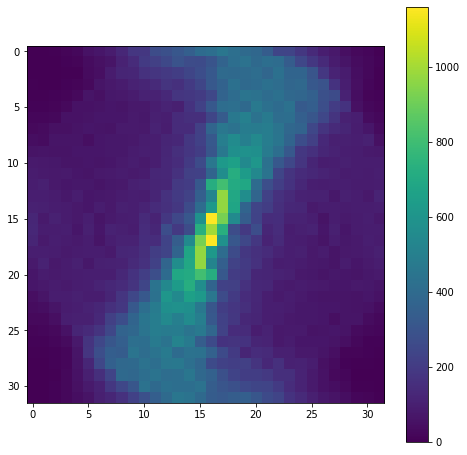

In [30]:
plt.imshow(jnp.fft.fftshift(points_v_nn[:,:,0])); plt.colorbar()

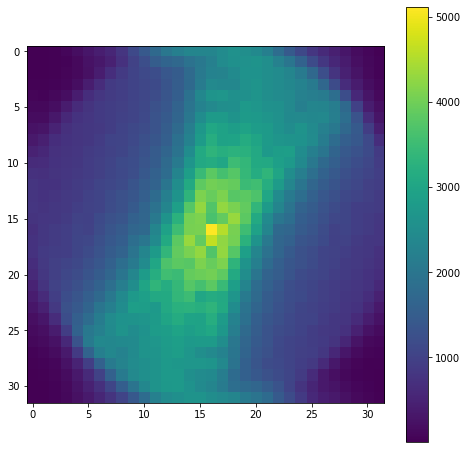

In [31]:
mip_z((np.fft.fftshift(points_v_tri)))
plt.colorbar()

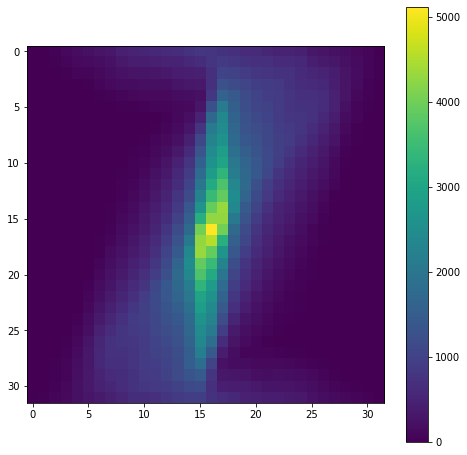

In [32]:
mip_x((np.fft.fftshift(points_v_tri)))
plt.colorbar()

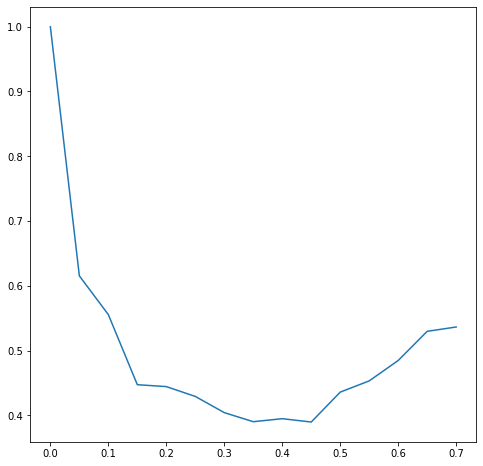

In [33]:
res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
plt.plot(res_spu, spu_nn)

### SGD

In [34]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
alpha = 10 # this alpha works well for full 128 x 128 x 128 volume with mask
batch_size = 2
N_iter = 1000  
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Iter 0: mean loss = 22122.55648399855
Iter 100: mean loss = 17595.35734326741
Iter 200: mean loss = 16213.03410924583
Iter 300: mean loss = 14718.796607451452
Iter 400: mean loss = 14150.802484363441
Iter 500: mean loss = 14068.631414344676
Iter 600: mean loss = 13580.846296204421
Iter 700: mean loss = 13860.195307186315
Iter 800: mean loss = 14255.023176002804
Iter 900: mean loss = 13780.093413861268
Final loss function (over all data) =  13752.274763563846
Relative error =  0.819248323014335


In [35]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Final loss function (over all data) =  13752.274763563846
Relative error =  0.819248323014335


Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

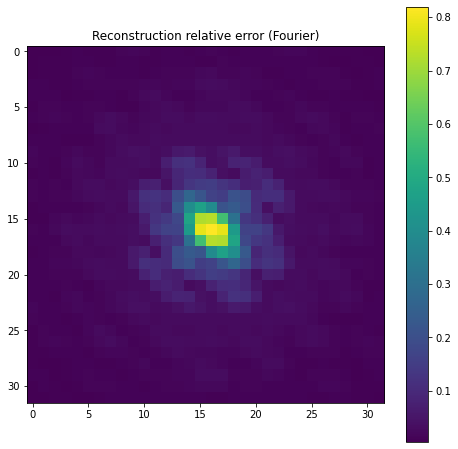

In [36]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

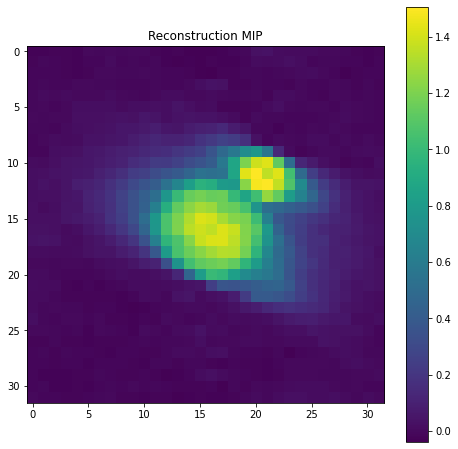

In [37]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

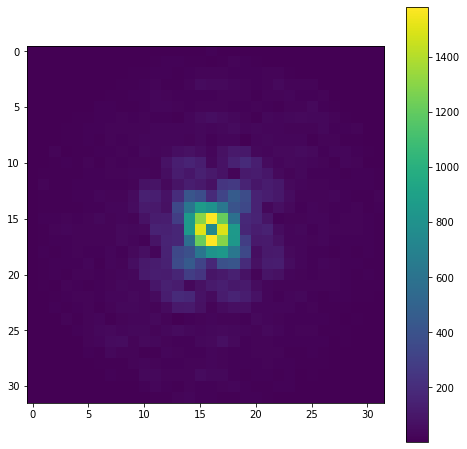

In [38]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

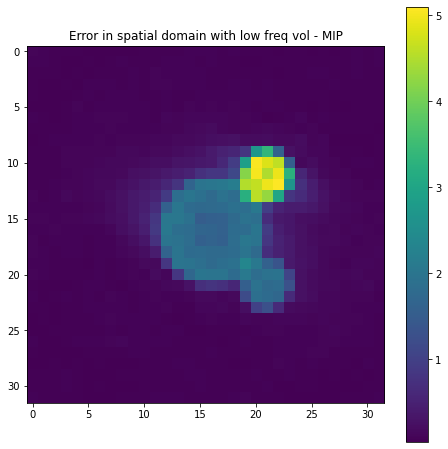

In [39]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

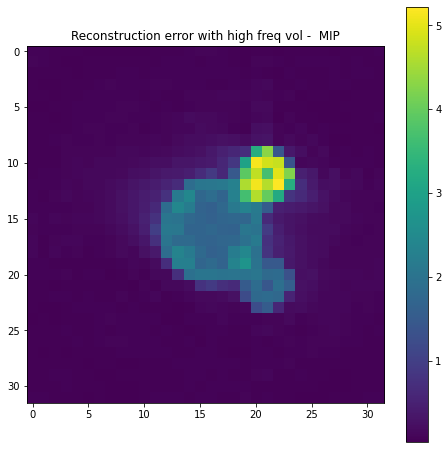

In [40]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

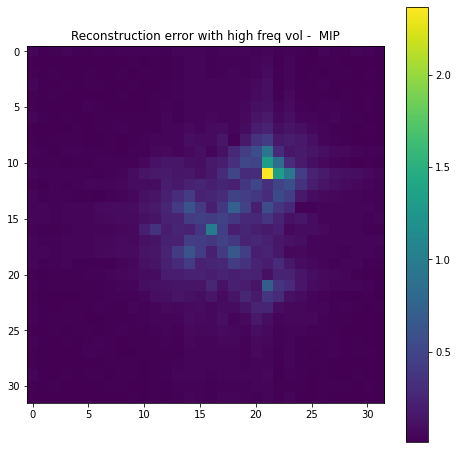

In [41]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')